## Taxi environment



Taxi environment is part of the Toy Text environments. The Taxi Problem involves navigating to passengers in a grid world, picking them up and dropping them off at one of four locations.

**Documentation**: https://gymnasium.farama.org/environments/toy_text/taxi/


There are four designated pick-up and drop-off locations (Red, Green, Yellow and Blue) in the 5x5 grid world. The taxi starts off at a random square and the passenger at one of the designated locations.

The goal is move the taxi to the passenger’s location, pick up the passenger, move to the passenger’s desired destination, and drop off the passenger. Once the passenger is dropped off, the episode ends.

The player receives positive rewards for successfully dropping-off the passenger at the correct location. Negative rewards for incorrect attempts to pick-up/drop-off passenger and for each step where another reward is not received.

Map:

    +---------+
    |R: | : :G|
    | : | : : |
    | : : : : |
    | | : | : |
    |Y| : |B: |
    +---------+

**Action Space**

The action shape is (1,) in the range {0, 5} indicating which direction to move the taxi or to pickup/drop off passengers.

0: Move south (down) <br>
1: Move north (up)<br>
2: Move east (right)<br>
3: Move west (left)<br>
4: Pickup passenger<br>
5: Drop off passenger<br>

**Observation Space**
There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations.<br>
Destination on the map are represented with the first letter of the color.<br>
Passenger locations:<br>

- 0: Red
- 1: Green
- 2: Yellow
- 3: Blue
- 4: In taxi

Destinations:

- 0: Red
- 1: Green
- 2: Yellow
- 3: Blue

An observation is returned as an int() that encodes the corresponding state, calculated by ((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

**Reward**

- -1 per step unless other reward is triggered.
- +20 delivering passenger.
- -10 executing “pickup” and “drop-off” actions illegally.

An action that results a noop, like moving into a wall, will incur the time step penalty. Noops can be avoided by sampling the action_mask returned in info.


## Compute resources

1. **The Processing Unit** <br>
Local laptop: Processor AMD Ryzen 5 8640HS w/ Radeon 760M Graphics (3.50 GHz) <br>
System type: 64-bit operating system, x64-based processor <br>

2. **Memory** <br>
Installed RAM: 16.0 GB (15.3 GB usable)

3. **Software Environment** <br>
- Python version: 3.12.3
- PyTorch version: 2.9.1+cpu
- Gymnasium version: 1.2.3 

## Libraries

In [1]:
#!pip install moviepy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
import gymnasium as gym
from gymnasium.utils.save_video import save_video
import time
from IPython.display import clear_output

## Set up Agent and Policy

In [2]:
def set_seed(env, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    env.reset(seed=seed)

According to the rule of thumb, and a common architectual guideline in neural network design, the number of hidden neurons should be between the size of input layer and output layer. Number of inputs is 500 of discrete states. Number of outputs is 6 of discrete actions. 128 falls squarely in this range [2]. So, this number seems like complex enough to capture state features but small enough to generalize well.

In [3]:
class PolicyNetwork(nn.Module):
    def __init__(self, n_states, n_actions, hidden_dim=128):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(n_states, hidden_dim) # Defines the input layer (maps 500 discrete env states to 128-node hidden layer) 
        self.fc2 = nn.Linear(hidden_dim, n_actions) # Defines output layer (maps 128 hidden neurons to 6 possible actions available to the taxi)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Passes the data through the first layer and the ReLU activation function
        x = self.fc2(x) # Passes the data through the second layer
        return F.softmax(x, dim=-1) # Returns probabilities for each action (discrete space) (softmax function)

The ReinforceAgent class serves as a direct implementation of the REINFORCE algorithm, which optimizes policy parameters $\theta$ to increase the expected sum of discounted rewards. To process the 500 discrete states of the Taxi-v3 environment through a neural network, states are transformed into one-hot encoded vectors. This ensures each state is treated as a unique categorical entity, preventing the model from assuming an incorrect numerical relationship between state indices. Then, the agent utilizes a categorical distribution based on the softmax output of the policy network. This enables a stochastic policy $\pi(a|s)$ where actions are sampled according to their probabilities, stimulating  exploration during training.

After each episode, the agent calculates the discounted return $R$ for every time step $t$. The parameters $\theta$ are updated using the gradient of the log-probability of the chosen actions, scaled by the realized returns. Returns are standardized (normalized) to stabilize training, a crucial step for managing the high variance inherent in policy gradient methods. Additionally, an entropy term is subtracted from the loss function to penalize early convergence to a single action, thereby encouraging the agent to continue exploring diverse trajectories.

In [ ]:
# REINFORCE Agent 
class ReinforceAgent:
    def __init__(self, n_states, n_actions, lr, gamma):
        self.n_states = n_states
        self.gamma = gamma # discount factor (future reward vs. immediate one)
        self.policy = PolicyNetwork(n_states, n_actions) # initialize policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr) # optimiser to perform Gradient Descent on the policy parameter theta

    # prepares the state s  
    def one_hot(self, state):
        v = np.zeros(self.n_states)
        v[state] = 1.0 # changes current state from 0 to 1
        return torch.FloatTensor(v) # convert list into Tensor 

    # calculates pi and picks an action a
    def select_action(self, state): 
        state_tensor = self.one_hot(state) # convert environment integer state into 500-wide vector
        probs = self.policy(state_tensor) # process the vector and outputs 6 probabilities for each action
        m = Categorical(probs) # creates a categorical distribution based on the probabilities (pi(a|s)) (stochastic selection) 
        action = m.sample() # samples an action according to the distribution
        return action.item(), m.log_prob(action), m.entropy()

    def update_policy(self, rewards, log_probs, entropies):
        # Calculate discounted returns
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.gamma * R
            returns.insert(0, R)
        
        returns = torch.tensor(returns) # convert rewards to a PyTorch tensor

        # (normalize reward) standardize returns to reduce variance 
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        policy_loss = []
        for log_prob, R, entropy in zip(log_probs, returns, entropies):
            # We subtract entropy to encourage exploration of new pathes
            policy_loss.append(-log_prob * R - 0.1 * entropy)
        
        self.optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        self.optimizer.step()

The primary training loop is designed to test the impact of Reward Shaping. In the 'enhanced' mode, we didn't just wait for the +20 "success" reward at the end (the sparse signal). Instead, the Manhattan distance between the taxi and its current target (passenger or destination) is calculated and added penalty proportional to that distance. By providing a dense reward signal proportional to this distance, we mitigate the "sparse reward" problem where the agent only receives positive feedback upon successful delivery [5]. This guides the agent to move toward objectives more efficiently in early training phases.

However, why did we decide to choose Reward shaping method? As noted in the article, Reward shaping is the most straightforward way to "bootstrap" an agent's learning. In the Taxi-v3 environment, there are 500 states. Without the Manhattan distance "hints" we implemented, the agent might have needed millions of episodes just to find the passenger by pure luck.

In [5]:
# Training Loop
def train_taxi(episodes, lr, reward_mode, gamma, seed=42):
    env = gym.make("Taxi-v3")
    set_seed(env,seed)
    agent = ReinforceAgent(500, 6, lr=lr, gamma=gamma)
    
    history = {
        'episode': [],
        'reward': [],
        'success': [],
        'avg_reward_100': []
    }

    print(f"Starting training for {episodes} episodes...")

    for ep in range(episodes):
        state, _ = env.reset()
        rewards, log_probs, entropies = [], [], []
        done = False
        total_reward = 0
        
        # loop untill passenger is delivered or the 200-step limit is reached
        while not done:
            action, log_p, ent = agent.select_action(state)
            next_state, reward, term, trunc, _ = env.step(action)

            # Reward  
            if reward_mode == 'enhanced':
                taxi_row, taxi_col, pass_idx, dest_idx = env.unwrapped.decode(state) # decode to coordinates
                # if passenger not in the taxi, the "target" is passenger's location. Otherwise, "target" is passengers final destination
                target = env.unwrapped.locs[pass_idx] if pass_idx < 4 else env.unwrapped.locs[dest_idx] 
                # Manhattan Distance (reward mode provides a signal that is directly proportional to the number of steps the agent is away from the goal)
                dist = abs(taxi_row - target[0]) + abs(taxi_col - target[1]) 
                reward -= (dist * 0.1) # agent get a small penalty being far away (closer to passenger, distance decreases and penalty gets smaller)
            
            rewards.append(reward)
            log_probs.append(log_p)
            entropies.append(ent)
            state = next_state
            total_reward += reward
            done = term or trunc

        agent.update_policy(rewards, log_probs, entropies)
        
        # Save metrics
        history['episode'].append(ep)
        history['reward'].append(total_reward)
        history['success'].append(1 if any(r >= 20 for r in rewards) else 0)
        
        avg_100 = np.mean(history['reward'][-100:])
        history['avg_reward_100'].append(avg_100)

        if ep % 500 == 0:
            success_rate = np.mean(history['success'][-500:]) * 100
            print(f"Ep {ep} | Avg Reward (Last 100): {avg_100:.2f} | Success Rate: {success_rate:.1f}%")

    return pd.DataFrame(history)

## Parameters tuning

In [6]:
start_time = time.time()

# Parameters tuning 
lrs_to_test = [0.001, 0.0005]
gammas_to_test = [0.99, 0.90]
reward_modes = ['standard', 'enhanced']
all_results = []

for lr in lrs_to_test:
    for mode in reward_modes:
            for gamma in gammas_to_test:
                print(f"\n--- Testing LR: {lr} | Gamma: {gamma} | Mode: {mode} ---")
                df = train_taxi(episodes=5000, lr=lr, reward_mode=mode, gamma=gamma)
                
                # Calculate final metrics for this run
                final_avg = df['reward'].tail(100).mean()
                final_succ = df['success'].tail(100).mean() * 100
                
                all_results.append({
                    'Learning Rate': lr,
                    'Discount Factor': gamma,
                    'Reward Mode': mode,
                    'Final Avg Reward': final_avg,
                    'Final Success Rate': final_succ
                })

# Create a summary table for your presentation
summary_table = pd.DataFrame(all_results)
print("\n--- Hyperparameter Tuning Summary ---")
print(summary_table)

end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")


--- Testing LR: 0.001 | Gamma: 0.99 | Mode: standard ---
Starting training for 5000 episodes...
Ep 0 | Avg Reward (Last 100): -803.00 | Success Rate: 0.0%
Ep 500 | Avg Reward (Last 100): -508.19 | Success Rate: 4.2%
Ep 1000 | Avg Reward (Last 100): -481.87 | Success Rate: 5.4%
Ep 1500 | Avg Reward (Last 100): -506.64 | Success Rate: 6.6%
Ep 2000 | Avg Reward (Last 100): -489.39 | Success Rate: 6.0%
Ep 2500 | Avg Reward (Last 100): -432.54 | Success Rate: 10.6%
Ep 3000 | Avg Reward (Last 100): -446.47 | Success Rate: 12.8%
Ep 3500 | Avg Reward (Last 100): -500.24 | Success Rate: 14.6%
Ep 4000 | Avg Reward (Last 100): -437.47 | Success Rate: 20.0%
Ep 4500 | Avg Reward (Last 100): -395.95 | Success Rate: 25.2%

--- Testing LR: 0.001 | Gamma: 0.9 | Mode: standard ---
Starting training for 5000 episodes...
Ep 0 | Avg Reward (Last 100): -803.00 | Success Rate: 0.0%
Ep 500 | Avg Reward (Last 100): -200.63 | Success Rate: 0.6%
Ep 1000 | Avg Reward (Last 100): -200.00 | Success Rate: 0.0%
Ep 1

In [7]:
print(all_results)

[{'Learning Rate': 0.001, 'Discount Factor': 0.99, 'Reward Mode': 'standard', 'Final Avg Reward': -381.22, 'Final Success Rate': 37.0}, {'Learning Rate': 0.001, 'Discount Factor': 0.9, 'Reward Mode': 'standard', 'Final Avg Reward': -200.18, 'Final Success Rate': 0.0}, {'Learning Rate': 0.001, 'Discount Factor': 0.99, 'Reward Mode': 'enhanced', 'Final Avg Reward': -519.636, 'Final Success Rate': 37.0}, {'Learning Rate': 0.001, 'Discount Factor': 0.9, 'Reward Mode': 'enhanced', 'Final Avg Reward': -220.67299999999977, 'Final Success Rate': 0.0}, {'Learning Rate': 0.0005, 'Discount Factor': 0.99, 'Reward Mode': 'standard', 'Final Avg Reward': -466.46, 'Final Success Rate': 7.000000000000001}, {'Learning Rate': 0.0005, 'Discount Factor': 0.9, 'Reward Mode': 'standard', 'Final Avg Reward': -200.0, 'Final Success Rate': 0.0}, {'Learning Rate': 0.0005, 'Discount Factor': 0.99, 'Reward Mode': 'enhanced', 'Final Avg Reward': -607.1249999999999, 'Final Success Rate': 9.0}, {'Learning Rate': 0.00

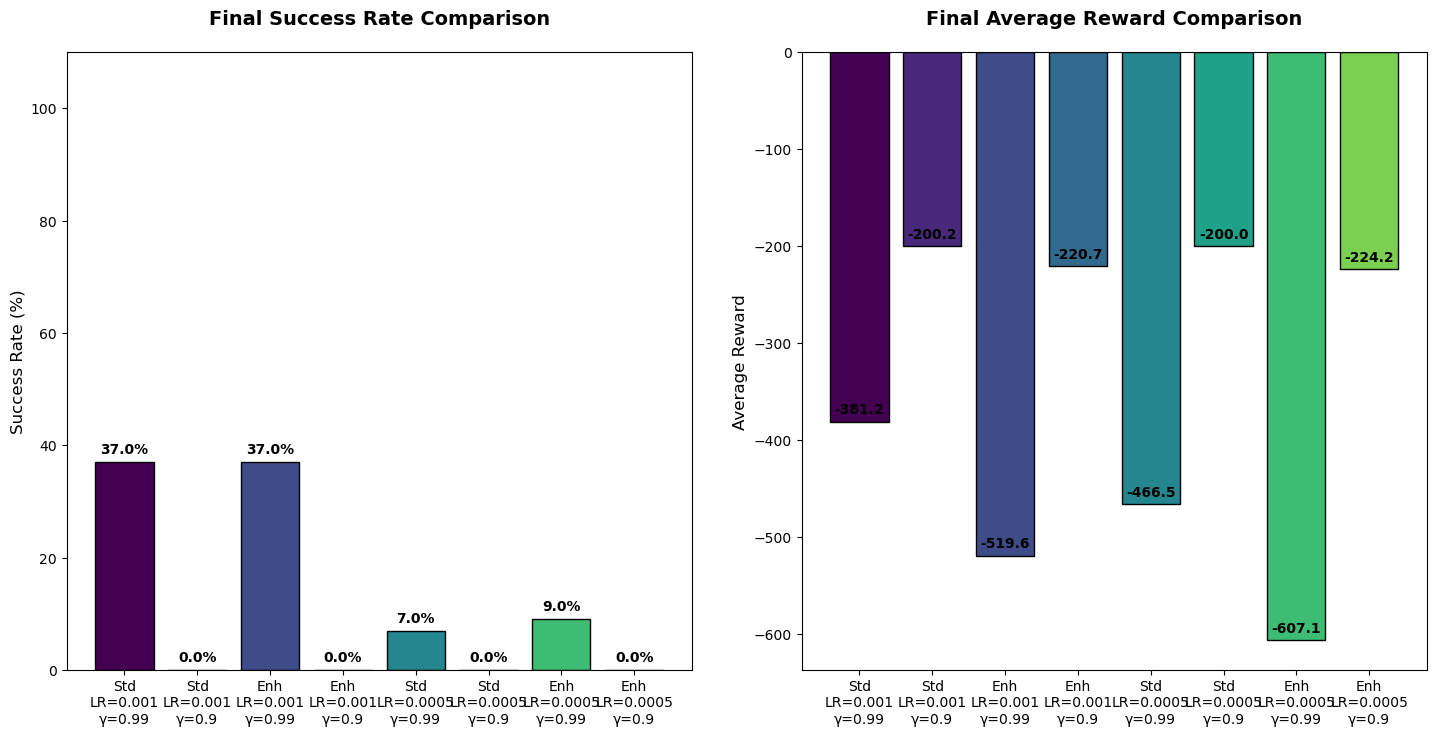

In [ ]:
def plot_summary_results(all_results):
    df = pd.DataFrame(all_results)
    
    # Std = Standard, Enh = Enhanced
    df['Label'] = (df['Reward Mode'].apply(lambda x: 'Std' if x == 'standard' else 'Enh') + 
                  "\nLR=" + df['Learning Rate'].astype(str) + 
                  "\nγ=" + df['Discount Factor'].astype(str)) 
    
    plt.figure(figsize=(15, 8)) 
    
    # Plot 1: Final Success Rate 
    plt.subplot(1, 2, 1)
    colors = plt.cm.viridis(np.linspace(0, 0.8, len(df))) # Professional color palette
    bars = plt.bar(df['Label'], df['Final Success Rate'], color=colors, edgecolor='black')
    
    plt.title('Final Success Rate Comparison', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Success Rate (%)', fontsize=12)
    plt.xticks(rotation=0, fontsize=10) 
    plt.ylim(0, 110) 
    
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', 
                 ha='center', va='bottom', fontweight='bold', fontsize=10)

    # Plot 2: Final Avg Reward 
    plt.subplot(1, 2, 2)
    bars_r = plt.bar(df['Label'], df['Final Avg Reward'], color=colors, edgecolor='black')
    plt.title('Final Average Reward Comparison', fontsize=14, fontweight='bold', pad=20)
    plt.ylabel('Average Reward', fontsize=12)
    plt.xticks(rotation=0, fontsize=10)
    
    for bar in bars_r:
        yval = bar.get_height()
        va_dir = 'bottom' if yval < 0 else 'top'
        offset = 5 if yval < 0 else -5
        plt.text(bar.get_x() + bar.get_width()/2, yval + offset, f'{yval:.1f}', 
                 ha='center', va=va_dir, fontweight='bold', fontsize=10)

    plt.tight_layout(pad=3.0) 
    plt.savefig('fixed_summary_chart.png', dpi=300) 
    plt.show()

plot_summary_results(all_results)

Firstly, we can notice that regardless of the learning rate or reward mode, every run with a discount factor of 0.9 resulted in a 0% success rate. A gamma of 0.9 likely caused the agent to prioritize immediate rewards too heavily, preventing it from valuing the long-term sequence of actions needed to reach the goal. To achieve any level of success, a higher discount factor was required to maintain a long exploration. 

Secondly, we can see that learning rate is the dominant factor. The difference between 0.001 and 0.0005 is massive. The 0.001 rate allowed the agent to reach a 37% success rate, whereas 0.0005 barely broke 9%. This indicates that for this specific architecture, a higher learning rate is necessary to escape the early "random walk" phase within 5,000 episodes. Notice that Standard and Enhanced at 0.001 both reached 37% success. However, the final average reward for enhanced is lower (more negative). Because we added a distance penalty, we are "taxing" the agent for being far from the goal.

The lower reward in the enhanced mode is a direct result of the distance penalty. Because the agent is constantly penalised for its distance from the target, the total reward will naturally be lower than the standard mode, even if the agent is performing the task successfully.

## Train function and evaluation

The transition from the initial train_taxi prototype to the final_train_taxi production pipeline involved several key architectural and logic refinements. The first is policy persistence. The function was modified to return the trained ReinforceAgent object alongside the performance history. This allows the learned policy parameters ($\theta$) to be saved and reused for evaluation or visualization without repeating the computationally intensive training process.

Next change was separation of reward signals. The logging logic was updated to track total_real_reward (the raw feedback from the environment) independently from the "Enhanced" rewards used for gradient calculations. This ensures that final performance metrics accurately reflect the agent's ability to solve the core Taxi-v3 task (-1 per step, +20 for delivery) rather than artificial shaping signals. 

Additionally, some operations were removed for better performance optimization. And finally, for reproducibility, set_seed during initialization  was integrated to fix the randomness of both the environment and the neural network weights.

In [8]:
def final_train_taxi(episodes, lr, mode, seed=42):
    env = gym.make("Taxi-v3")
    set_seed(env, seed)
    agent = ReinforceAgent(500, 6, lr=lr, gamma=0.99) # use the best gamma value 
    history = {'reward': [], 'success': []}

    for ep in range(episodes):
        state, _ = env.reset()
        rewards, log_probs, entropies = [], [], []
        done = False
        total_real_reward = 0 # Captures the -1, +20, -10 from the environment
        
        while not done:
            action, log_p, ent = agent.select_action(state)
            next_state, reward, term, trunc, _ = env.step(action)
            total_real_reward += reward
            
            # Reward Shaping
            if mode == 'enhanced':
                taxi_row, taxi_col, pass_idx, dest_idx = env.unwrapped.decode(state)
                target = env.unwrapped.locs[pass_idx] if pass_idx < 4 else env.unwrapped.locs[dest_idx]
                dist = abs(taxi_row - target[0]) + abs(taxi_col - target[1])
                reward -= (dist * 0.1) 
            
            rewards.append(reward)
            log_probs.append(log_p)
            entropies.append(ent)
            state = next_state
            done = term or trunc

        agent.update_policy(rewards, log_probs, entropies)
        history['reward'].append(total_real_reward)
        history['success'].append(1 if any(r >= 20 for r in rewards) else 0)
        
    return pd.DataFrame(history), agent # return agent object as well

The evaluation phase utilizes a deterministic Greedy Policy to validate the agent's mastery of the environment. By selecting actions through argmax on the policy distribution $\pi_{\theta}$ and disabling exploratory sampling, we measure the agent's peak performance on the original, un-shaped reward signal of the Taxi-v3 task.

In [9]:
def evaluate_agent(agent, episodes=100):
    """
    Evaluates the agent's performance using a greedy policy 
    (no exploration, no reward shaping).
    """
    eval_env = gym.make("Taxi-v3")
    # Note: We do not use the 'enhanced' reward logic here to get the 'true' score
    
    total_rewards = []
    successes = 0
    
    for ep in range(episodes):
        state, _ = eval_env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # greedy action: pick the action with highest probability
            state_tensor = agent.one_hot(state)
            with torch.no_grad():
                probs = agent.policy(state_tensor)
            action = torch.argmax(probs).item()
            
            state, reward, terminated, truncated, _ = eval_env.step(action)
            episode_reward += reward
            done = terminated or truncated
            
            if reward == 20:
                successes += 1
                
        total_rewards.append(episode_reward)
        
    avg_reward = np.mean(total_rewards)
    success_rate = (successes / episodes) * 100
    
    print(f"\n--- FINAL EVALUATION (Greedy Policy) ---")
    print(f"Mean Reward over {episodes} episodes: {avg_reward:.2f}")
    print(f"Success Rate: {success_rate:.1f}%")
    
    return avg_reward, success_rate

In [ ]:
start_time = time.time()
# Run training session
df_best_history_enh_15k, best_agent_enh_15k = final_train_taxi(episodes=15000, lr=0.001, mode='enhanced', seed=42)

# Evaluate the agent (the final phase)
final_score_enh_15k, final_success_enh_15k = evaluate_agent(best_agent_enh_15k, episodes=100)

end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")


--- FINAL EVALUATION (Greedy Policy) ---
Mean Reward over 100 episodes: -122.45
Success Rate: 37.0%
Total tuning time: 26.02 minutes


In [15]:
def plot_best_run(df):
    plt.figure(figsize=(14, 5))

    # Reward Progress
    plt.subplot(1, 2, 1)
    plt.plot(df['reward'], alpha=0.2, color='blue', label='Raw')
    plt.plot(df['reward'].rolling(100).mean(), color='red', label='MA 100')
    plt.title("Reward Progress", fontsize=14)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()

    # Success Rate Progress
    plt.subplot(1, 2, 2)
    success_ma = df['success'].rolling(100).mean() * 100
    plt.plot(success_ma, color='green')
    plt.title("Success Rate Progress (%)", fontsize=14)
    plt.xlabel("Episode")
    plt.ylabel("Success %")
    
    plt.tight_layout()
    plt.show()

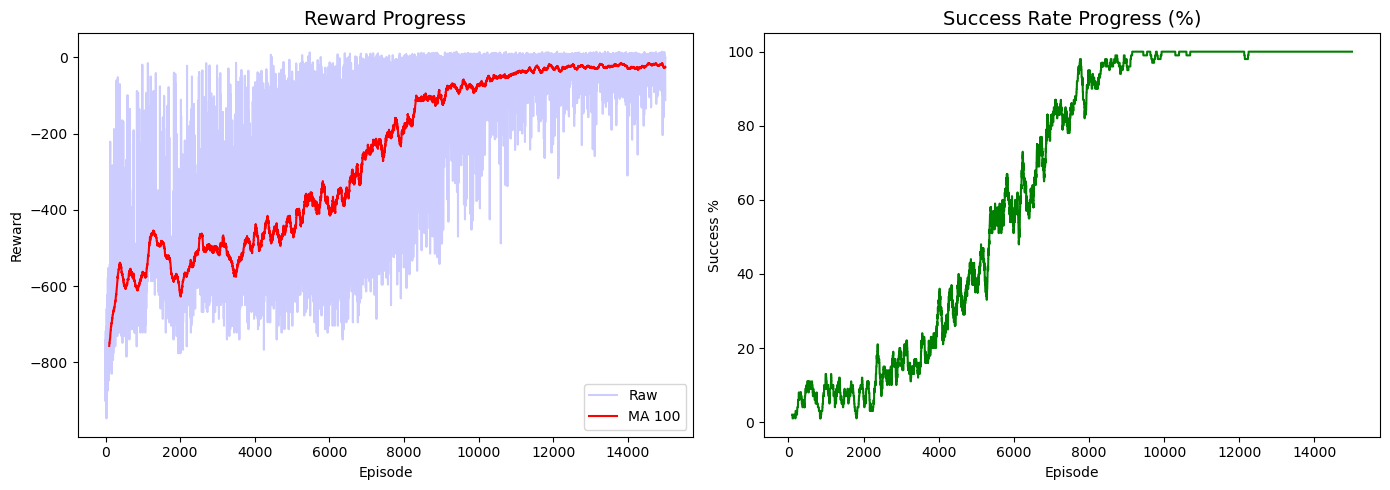

In [16]:
plot_best_run(df_best_history_enh_15k)

In [ ]:
start_time = time.time()
# Run training session
df_best_history_st_15k, best_agent_st_15k = final_train_taxi(episodes=15000, lr=0.001, mode='standard', seed=42)

# Evaluate the agent (the final phase)
final_score_st_15k, final_success_st_15k = evaluate_agent(best_agent_st_15k, episodes=100)

end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")


--- FINAL EVALUATION (Greedy Policy) ---
Mean Reward over 100 episodes: -91.40
Success Rate: 52.0%
Total tuning time: 26.47 minutes


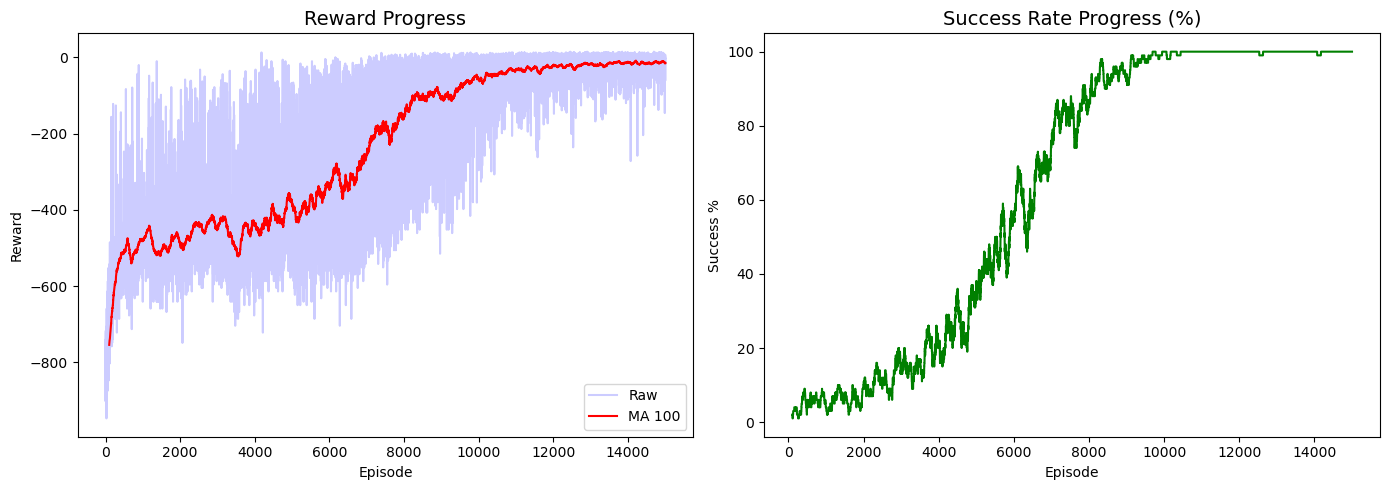

In [18]:
plot_best_run(df_best_history_st_15k)

In [ ]:
start_time = time.time()
# Run training session
df_best_history_st_30k, best_agent_st_30k = final_train_taxi(episodes=30000, lr=0.001, mode='standard', seed=42)

# Evaluate the agent (the final phase)
final_score_st_30k, final_success_st_30k = evaluate_agent(best_agent_st_30k, episodes=100)
end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")


--- FINAL EVALUATION (Greedy Policy) ---
Mean Reward over 100 episodes: -68.41
Success Rate: 63.0%
Total tuning time: 23.32 minutes


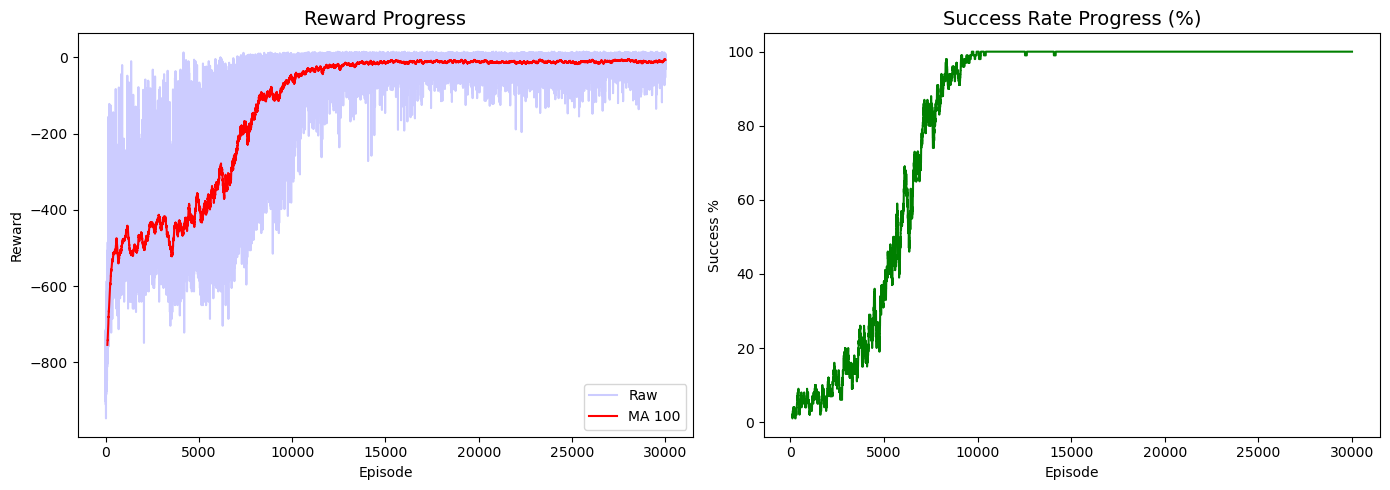

In [21]:
plot_best_run(df_best_history_st_30k)


--- FINAL EVALUATION (Greedy Policy) ---
Mean Reward over 100 episodes: -41.49
Success Rate: 76.0%


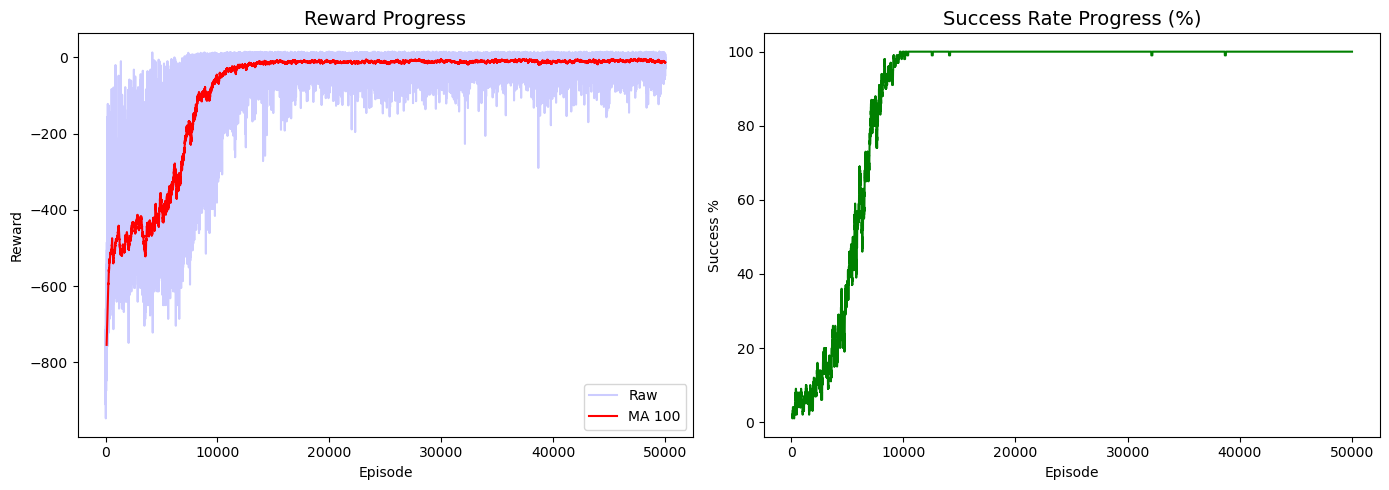

Total tuning time: 42.37 minutes


In [ ]:
start_time = time.time()
# Run training session
df_best_history_st_50k, best_agent_st_50k = final_train_taxi(episodes=50000, lr=0.001, mode='standard', seed=42)

# Evaluate the agent (the final phase)
final_score_st_50k, final_success_st_50k = evaluate_agent(best_agent_st_50k, episodes=100)
plot_best_run(df_best_history_st_50k)
end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")


--- FINAL EVALUATION (Greedy Policy) ---
Mean Reward over 100 episodes: -37.11
Success Rate: 78.0%


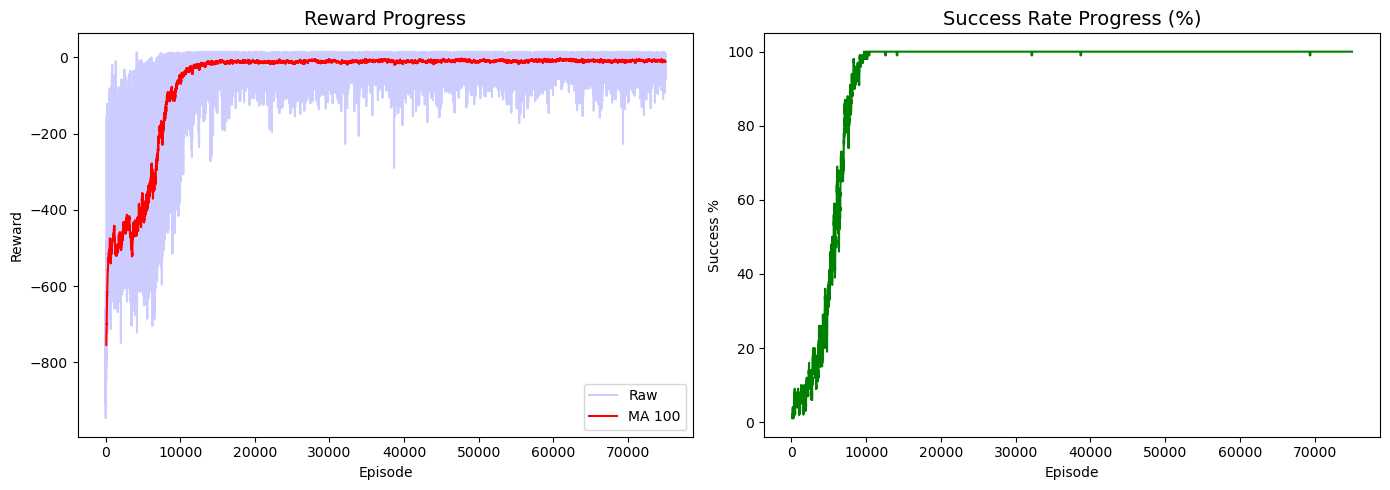

Total tuning time: 54.76 minutes


In [25]:
# Can the agent perform better for the 75k episodes? 
start_time = time.time()
# Run training session
df_best_history_st_75k, best_agent_st_75k = final_train_taxi(episodes=75000, lr=0.001, mode='standard', seed=42)

# Evaluate the agent (the final phase)
# We pass the 'best_agent' we just trained into the function
final_score_st_75k, final_success_st_75k = evaluate_agent(best_agent_st_75k, episodes=100)
plot_best_run(df_best_history_st_75k)
end_time = time.time()
print(f"Total tuning time: {(end_time - start_time) / 60:.2f} minutes")

In [ ]:
folder_name = "weights"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# Your lists are correct
epis_names = ["taxi_30k.pth", "taxi_50k.pth", "taxi_75k.pth"]
best_agents = [best_agent_st_30k, best_agent_st_50k, best_agent_st_75k]

for agent, name in zip(best_agents, epis_names):
    file_path = os.path.join(folder_name, name)
    
    torch.save(agent.policy.state_dict(), file_path)

The experiments conducted on the Taxi-v3 environment using the REINFORCE algorithm show a significant correlation between the number of training episodes and the stability of the learned policy. By evaluating the agent under a deterministic Greedy Policy, we can draw several conclusions.

Firstly, at the 15,000-episode mark, a clear performance gap was observed between the reward modes:

- Enhanced Mode (37% Success, -122.45 Reward). While reward shaping (Manhattan distance) provided a denser gradient to bootstrap early learning, it likely introduced bias that slowed the agent's ability to reach a high-level success rate within this timeframe.

- Standard Mode (52% Success, -91.40 Reward).  The "sparse" standard environment proved superior even at this early stage. This suggests that for a discrete state-space like Taxi-v3, the "pure" reward signal allows the agent to converge more accurately toward the global optimum without the distraction of additional hints.

Secondly, we can notice the optimal convergence at 50,000 episodes.
The 50,000-episode run represents the golden mean for this specific implementation. The jump from 15k to 50k episodes showed a 24% increase in success rate. However, the jump from 50k to 75k episodes only showed a 2% increase. This suggests that by 50,000 episodes, the agent has effectively generalized the navigation and delivery logic across the vast majority of the 500 possible starting states. This also demonstrates that the REINFORCE agent requires a high volume of trajectories to overcome the high variance inherent in policy gradients. 

While 75,000 episodes provide the best overall results, the marginal gains in success rate (from 76% to 78%) suggest that the agent has reached a stable plateau.

## Display and record videos

In [ ]:
def visualize_taxi_agent(agent, num_episodes=10):
    vis_env = gym.make("Taxi-v3", render_mode="human") 
    
    for ep in range(num_episodes):
        state, _ = vis_env.reset()
        done = False
        
        print(f"--- Visualizing Episode {ep+1} ---")
        time.sleep(1)
        
        while not done:
            # Greedy action selection
            state_tensor = agent.one_hot(state)
            with torch.no_grad():
                probs = agent.policy(state_tensor)
            action = torch.argmax(probs).item()
            state, reward, terminated, truncated, _ = vis_env.step(action)
            done = terminated or truncated
            vis_env.render()
            
        print(f"Episode {ep+1} complete!")
        time.sleep(2)
        
    vis_env.close()


visualize_taxi_agent(best_agent_st_50k)

--- Visualizing Episode 1 ---
Episode 1 complete!
--- Visualizing Episode 2 ---
Episode 2 complete!
--- Visualizing Episode 3 ---
Episode 3 complete!
--- Visualizing Episode 4 ---
Episode 4 complete!
--- Visualizing Episode 5 ---
Episode 5 complete!
--- Visualizing Episode 6 ---
Episode 6 complete!
--- Visualizing Episode 7 ---
Episode 7 complete!
--- Visualizing Episode 8 ---
Episode 8 complete!
--- Visualizing Episode 9 ---
Episode 9 complete!
--- Visualizing Episode 10 ---
Episode 10 complete!


In [ ]:
def record_best_agent_video(agent, folder="policy_taxi_video", episodes=10):
    env = gym.make("Taxi-v3", render_mode="rgb_array") # to "grab" the pixels for the video file
    
    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        frames = []

        print(f"Recording Video for Episode {ep+1}...")
        
        while not done:
            # Capture the current frame
            frames.append(env.render())
            
            # Greedy action selection
            state_tensor = agent.one_hot(state)
            with torch.no_grad():
                probs = agent.policy(state_tensor)
            action = torch.argmax(probs).item()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
        
            if len(frames) > 200:
                break

        #  create the .mp4 file in the directory
        save_video(
            frames,
            folder,
            fps=8, # speed of the video
            name_prefix=f"taxi_50k-episode-{ep}"
        )
        print(f"Successfully saved: {folder}/taxi_50k-episode-{ep}.mp4")

    env.close()


record_best_agent_video(best_agent_st_50k)

## Evaluation

The evaluation executes using a Deterministic Greedy Policy. While the REINFORCE agent is stochastic during training (to facilitate exploration), the evaluation phase utilizes torch.argmax to select the action with the maximum estimated probability. torch.no_grad() ensures that the computational graph is not tracked, reducing memory overhead and preventing accidental weight updates during testing.

In [ ]:
def evaluate_model(agent, env_name='Taxi-v3', num_episodes=500):
    eval_env = gym.make(env_name)
    success_count = 0
    total_rewards = []
    total_steps = []
    
    # disables dropout if any, evaluation mode
    agent.policy.eval() 
    
    print(f"Evaluation over {num_episodes} episodes.")

    with torch.no_grad(): # Disable gradient calculation 
        for episode in range(num_episodes):
            state, _ = eval_env.reset()
            episode_reward = 0
            steps = 0
            done = False
            
            while not done and steps < 200: 
                state_tensor = agent.one_hot(state)
                probs = agent.policy(state_tensor)
                
                # Pick the action with the absolute highest probability (greedy selection)
                action = torch.argmax(probs).item()
                
                next_state, reward, terminated, truncated, _ = eval_env.step(action)
                done = terminated or truncated
                
                episode_reward += reward
                steps += 1
                state = next_state
                
                # Environment reward
                if reward == 20:
                    success_count += 1
            
            total_rewards.append(episode_reward)
            total_steps.append(steps)

    # Add metrics
    avg_reward = np.mean(total_rewards)
    success_rate = (success_count / num_episodes) * 100
    avg_steps = np.mean(total_steps)

    print("--- Evaluation Metrics ---")
    print(f"Total Episodes:  {num_episodes}")
    print(f"Success Rate:    {success_rate:.2f}%")
    print(f"Average Reward:  {avg_reward:.2f}")
    print(f"Average Steps:   {avg_steps:.2f}")
    
    return total_rewards, success_rate, total_steps

In [ ]:
state_size = 500
action_size = 6
reinforce_agent = ReinforceAgent(state_size, action_size, lr=0.001, gamma=0.99)
reinforce_agent.policy.load_state_dict(torch.load("weights/taxi_50k.pth"))
reinforce_agent.policy.eval()

PolicyNetwork(
  (fc1): Linear(in_features=500, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

The agent utilizes MLP as a function approximator for the policy. The architecture consists of a 500-unit input layer (matching the discrete observation space) and a 6-unit output layer (matching the action space), with a 128-neuron hidden layer, as we also utilized and described above. Using 500 discrete states prevents the neural network from assuming a false ordinal relationship between state indices, allowing it to treat each location/passenger/destination combination as a unique category. The evaluation utilized the weights from the 50k training episode (taxi_50k.pth). This checkpoint was chosen as it represents the optimal convergence point, where the learning curve plateaued and further training provided diminishing returns, as we can see from the plots above. 

In [18]:
start_time = time.time()
eval_rewards, final_success_rate, total_steps = evaluate_model(reinforce_agent)
end_time = time.time()
print(f"Total evaluation time: {(end_time - start_time) / 60:.2f} minutes")

Evaluation over 500 episodes.
--- Evaluation Metrics ---
Total Episodes:  500
Success Rate:    77.00%
Average Reward:  -39.27
Average Steps:   55.44
Total evaluation time: 0.03 minutes


To prevent early convergence to sub-optimal local minima, we implemented entropy regularization within the loss function. By penalizing low-entropy policies (with a coefficient of beta=0.1), we encouraged the agent to maintain a degree of exploration throughout the 50,000 training episodes. While this strategy successfully enabled the agent to discover a reliable pick-up and drop-off sequence (77% success rate), the final evaluation step count of 55 suggests that the reward signal (+20) ultimately dominated the entropy signal. This indicates that the agent prioritized policy stability and mission success over making less number of steps. 

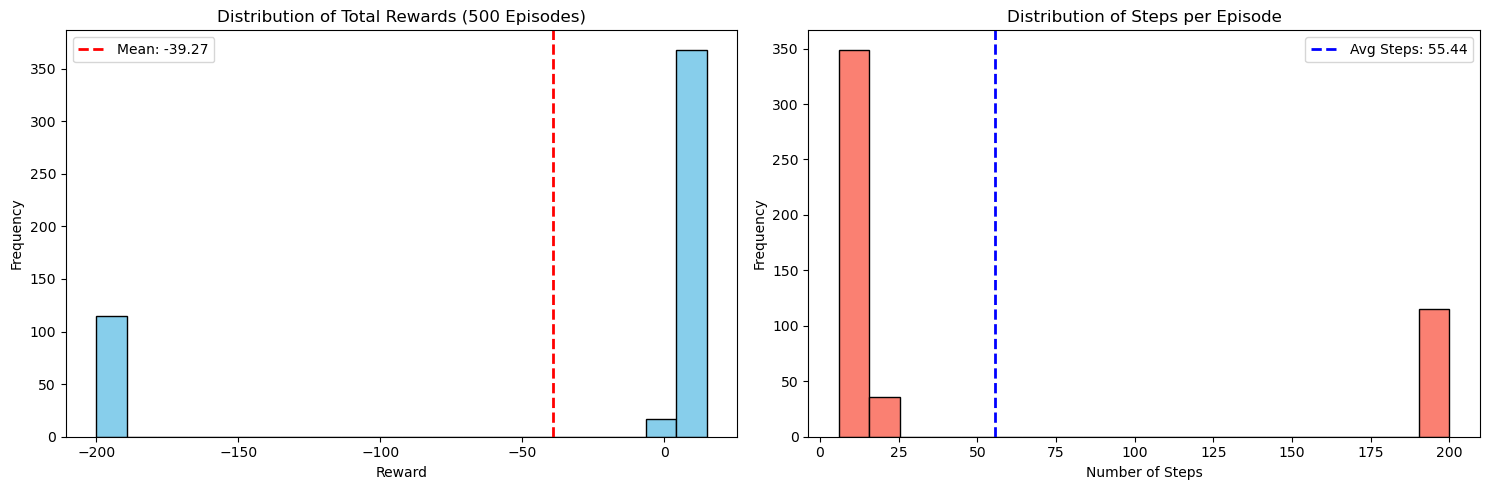

In [ ]:
def visualize_evaluation(rewards, steps):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Histogram of Rewards
    ax1.hist(rewards, bins=20, color='skyblue', edgecolor='black')
    ax1.set_title('Distribution of Total Rewards (500 Episodes)')
    ax1.set_xlabel('Reward')
    ax1.set_ylabel('Frequency')
    ax1.axvline(np.mean(rewards), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(rewards):.2f}')
    ax1.legend()

    # Histogram of Steps
    ax2.hist(steps, bins=20, color='salmon', edgecolor='black')
    ax2.set_title('Distribution of Steps per Episode')
    ax2.set_xlabel('Number of Steps')
    ax2.set_ylabel('Frequency')
    ax2.axvline(np.mean(steps), color='blue', linestyle='dashed', linewidth=2, label=f'Avg Steps: {np.mean(steps):.2f}')
    ax2.legend()

    plt.tight_layout()
    plt.show()

visualize_evaluation(eval_rewards, total_steps)

On the other hand, despite the average number of steps and average reward, we can see that agent is finding the optimal or near-optimal path in many cases. Around 20% of the episodes with reward -200 pull the mathematical average down. We also can see that in most of the cases the number of steps for the agent varies between 5-25. We can see also 200 steps bar, where the "timeouts" happens.  

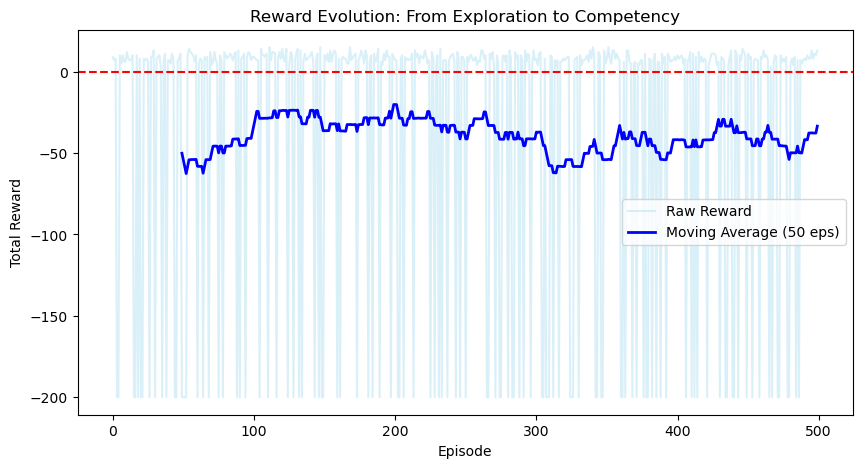

In [ ]:
# Calculate a rolling average (over the last 100 episodes)
data = pd.Series(eval_rewards)
rolling_mean = data.rolling(window=50).mean()

plt.figure(figsize=(10, 5))
plt.plot(data, alpha=0.3, color='skyblue', label='Raw Reward') # noise color
plt.plot(rolling_mean, color='blue', linewidth=2, label='Moving Average (50 eps)') # Bold for trend
plt.title('Reward Evolution: From Exploration to Competency')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.axhline(y=0, color='red', linestyle='--') # The "Success" threshold
plt.legend()
plt.show()

The variance observed during evaluation is a function of the environment's randomized starting configurations rather than model instability. The spread of rewards between +15 and -50 reflects the varying distances between the taxi, passenger, and destination across the 500-episode sample. A secondary cluster of data points at the -200 reward threshold represents the 23% failure rate. These outliers indicate specific 'edge-case' states where the greedy policy (argmax) enters a cycle. 

## Resources: 
1. Course materials "Introduction to Reinforcement Learning" by Jakub Bandurski. University of Warsaw, Faculty of Economic Science.  
2. https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw#:~:text=There%20are%20some%20empirically%20derived,the%20input%20and%20output%20layers.
3. https://www.datacamp.com/tutorial/policy-gradient-theorem
4. https://medium.com/@dixitaniket76/exploring-policy-gradient-methods-a-deep-dive-into-reinforce-with-cartpole-6fec94b36d27
5. https://medium.com/@m.k.daaboul/dealing-with-sparse-reward-environments-38c0489c844d